In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.interpolate import griddata
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from scipy.interpolate import interp2d
import matplotlib.pylab as pylab
import pandas as pd
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from multiprocessing import Pool
from scipy.optimize import brentq

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

In [3]:
SNR = 5.098 # known from original fits file
sky_zero_point = -21.1 # mag
photflam = 6.9548454E-20 # inverse sensitivity ergs/cm2/Ang/electron
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
psf2 = fits.open("../data/tiny_psf00_psf.fits")[0].data
im[im < 0] = 0
image_principales = np.loadtxt("../data/images_positions.txt")[:4] ## B, A, C, D, G, S
f_vega = 8.60e-10 

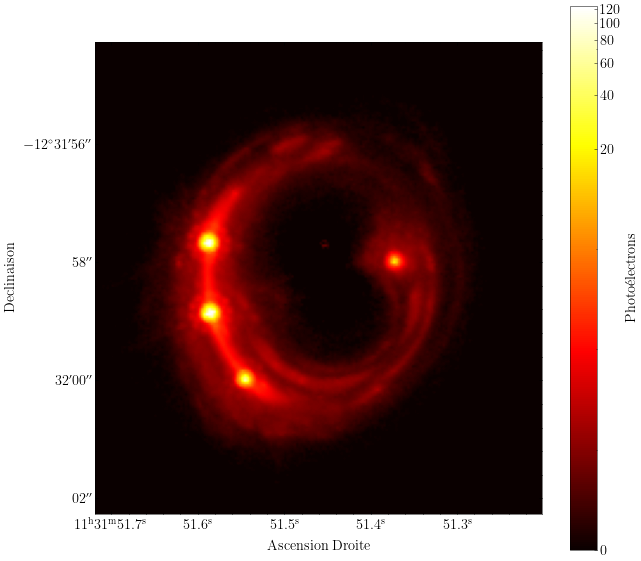

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="hot", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
plt.colorbar(label="Photoélectrons")
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

# Find 4 images positions

In [5]:
# Trouver la position des 4 images principales
mean, median, std = sigma_clipped_stats(im*photflam,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std, sky=0)
image_principales = daofind(im * photflam).to_pandas().sort_values("flux", ascending=False).iloc[:7]
# flux vega source # source https://www.stsci.edu/instruments/observatory/PDF/scs8.rev.pdf (table I)
image_principales["mag_vega"] = image_principales["mag"] - 2.5 * np.log10(5.*std) + 2.5 * np.log10(8.6e-10)
print(f"threshold sigma = {5 * std}")
image_principales

1.220648579128517e-21 0.0 2.424261801672095e-21
threshold sigma = 1.2121309008360475e-20


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,mag_vega
13,14,48.180640,114.082430,0.421323,-0.140638,-0.164836,25,0,8.617534e-18,604.557632,-6.953594,20.173778
8,9,47.886994,84.235971,0.459638,0.277774,-0.305937,25,0,8.461834e-18,503.271889,-6.754507,20.372866
3,4,62.942722,56.275357,0.687271,0.069577,0.076066,25,0,4.572649e-18,268.928129,-6.074091,21.053282
12,13,125.880274,106.210428,0.665696,0.205851,0.011222,25,0,1.239891e-18,72.616587,-4.652590,22.474783
15,16,50.009621,121.875850,0.520219,-0.945623,0.909309,25,0,1.787923e-19,3.416182,-1.333853,25.793520
5,6,57.831731,63.038661,0.450558,-0.808945,0.501900,25,0,1.358774e-19,3.412578,-1.332706,25.794666
2,3,71.155908,53.872313,0.566567,-0.269242,-0.217103,25,0,1.385412e-19,3.343537,-1.310515,25.816857


In [6]:
# coordinate system in arcseconds, centered
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M*N//2]).to(u.arcsec)

In [7]:
x_image = image_principales["xcentroid"].to_numpy()[[1, 0, 2, 3]]
y_image = image_principales["ycentroid"].to_numpy()[[1, 0, 2, 3]]
positions = wcs.pixel_to_world(x_image, y_image)
x_image = (positions.ra - x_center).to(u.arcsec).value
y_image = (positions.dec - y_center).to(u.arcsec).value
image_position = pd.DataFrame(np.column_stack([x_image, y_image]), columns=["theta_x", "theta_y"])
image_position

,theta_x,theta_y
0,1.889354,-0.630674
1,1.877251,0.563184
2,1.272489,-1.749133
3,-1.306581,0.248130


# Find magnitude

In [8]:
x = lens_sky.ra.to(u.arcsec) - x_center
y = lens_sky.dec.to(u.arcsec) - y_center
grid = np.column_stack([x, y])

In [9]:
# find flux near the centered pixel (integrate over the area)
ee = 0.611 # encircled energy, source https://www.stsci.edu/hst/instrumentation/acs/data-analysis/aperture-corrections
# collect 4 pixels closest to the image position (correspond to 0.1 arcsec since pixelscale is 0.05 arcsec)
A = []
f = []
for i in range(4):
    pos = image_position.to_numpy()[i]
    diff = np.square(pos - grid.value)
    dist = np.einsum("ij -> i", diff)
    indexes = np.argpartition(dist, kth=4)[:4]
    A.append(np.sum(im.ravel()[indexes]))
    f.append(photflam * np.sum(im.ravel()[indexes])/ee) # see e.g. https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints
mag = [-2.5 * np.log10(_f / f_vega) for _f in f]
A = np.array(A)
A

array([445.1407  , 400.79227 , 188.04726 ,  51.757866], dtype=float32)

# First sampling using the 4 images positions and flux

We model the AGN as an unresolved point in the source plane. Therefore, we have 3 parameters for the source to fit ($\beta_{xs}$, $\beta_{ys}$ and the AGN intensity $I_s$). We use a SIE model for the lens, which gives us an additional 5 parameters to fit ($\xi_{x\ell}$, $\xi_{y\ell}$, $e$, $\phi$ and $\theta_E$).
    See Keeton and Kochanek 1998, https://arxiv.org/pdf/astro-ph/9705194.pdf

La densité surfacique de masse projeté est
$$
    2 \frac{\Sigma}{\Sigma_{\mathrm{cr}}} = b \left[ (s^2 + x^2) + q^2y^2 \right]^{-1/2}
$$
Pour un profile SIE, $s\rightarrow 0$. On a que
$$
    b \equiv \sqrt{q}2\pi \left(\frac{v_c}{c}\right)^2 \frac{D_{\ell s}}{D_s}  = \sqrt{q}\theta_E
$$
où $e$ est l'ellipticité et $q$ le ratio elliptique ($q^2 = (1-e)/(1 + e)$). Le potentiel est
$$
    \Psi = x \alpha_{x} + y \alpha_{y} - b s \log \left[ (\psi + s)^2+ (1 - q^2)x^2 \right]^{1/2} + \mathrm{constant}
$$
Avec
$$
\alpha_{x} = \frac{b}{\sqrt{1 - q^2}} \arctan \left[ \frac{x\sqrt{1 - q^2}}{\psi + s} \right]
$$
$$
\alpha_{y} = \frac{b}{\sqrt{1 - q^2}} \tanh^{-1}\left[ \frac{y \sqrt{1 - q^2}}{\psi + q^2s} \right]
$$

Avec
$$
    \psi^2 = q^2(x^2 + s^2) + y^2
$$
Ce potentiel produit une magnification donné par
$$
M^{-1} = 1 - \frac{b}{\psi} - \frac{b^2 s}{\psi [(\psi + s)^2 + (1 - q^2)x^2]}
$$


In [10]:
class PseudoQuadSIELensModel:
    """
    # We assume the coordinate center is roughly in the middle of the lens #

    lens params: r_ein, q, phi, x0, y0
    source params: beta_x, beta_y, A
    
    r_ein: Einstein radius (in arcseconds)
    q: axis ratio
    phi: Orientation of the ellitpical profil (0 <= phi <= pi)
    (x0, y0): Position relative to coordinate center of the
        image plane grid (in arcseconds).
        
    beta: position of the AGN
    A: Photoelectron count expected in direct detection (amplitude of the signal)

    x_image: horizontal coordinate of the 4 images (arcsec)
    y_image: vertical coordinate of the 4 images (arcsec)
    A_image: Amplitude of images (in photoelectron count)

    plate_scale: Plate scale of the image, used as uncertainty for
        likelihood
    """
    def __init__(self, x_image, y_image, amp_images, plate_scale, amp_erro=1, kappa_ext=0, theta_c=1e-6, # assume very close to SIE
            forward_prior=None):
        self.theta1 = x_image
        self.theta2 = y_image
        self.images_amp = amp_images
        self.plate_scale = plate_scale
        self.amp_error = 1
        self.theta_c = theta_c
        self.backward_prior = [
            [0, 5],     # r_ein
            [0.01, 0.3],   # e
            [0, np.pi], # phi
            [-1., 1.],  # x0
            [-1., 1.],   # y0 # center taken to be near the center of the image by default ~within 1 arcsec radius
        ]
        self.forward_prior = self.backward_prior + [
            [-2, 2], # beta_x
            [-2, 2], # beta_y
            [1, 200], # A
        ]

#     def external_shear_potential(self, gamma_ext, phi_ext):
#         rho = np.hypot(self.theta1, self.theta2)
#         varphi = np.arctan2(self.theta2, self.theta1)
#         return 0.5 * gamma_ext * rho**2 * np.cos(2 * (varphi - phi_ext))

#     def external_shear_deflection(self, theta1, theta2, gamma_ext, phi_ext):
#         # see Meneghetti Lecture Scripts equation 3.83 (constant shear equation)
#         alpha1 = gamma_ext * (theta1 * np.cos(phi_ext) + theta2 * np.sin(phi_ext))
#         alpha2 = gamma_ext * (-theta1 * np.sin(phi_ext) + theta2 * np.cos(phi_ext))
#         return alpha1, alpha2
    
    def rotated_and_shifted_coords(self, phi, x0, y0):
        """
        Important to shift then rotate, we move to the point of view of the
        lens before rotating the lens (rotation and translation are not commutative).
        """
        theta1 = self.theta1.copy() - x0
        theta2 = self.theta2.copy() - y0
        rho = np.hypot(theta1, theta2)
        varphi = np.arctan2(theta2, theta1) - phi
        theta1 = rho * np.cos(varphi)
        theta2 = rho * np.sin(varphi)
        return theta1, theta2

    def potential(self, theta1, theta2, r_ein, e): # arcsec^2
        return r_ein * np.sqrt(theta1**2/(1-e) + (1-e)*theta2**2 + self.theta_c**2)

    def deflection_angles(self, theta1, theta2, r_ein, e): # arcsec
        psi = np.sqrt(theta1**2/(1-e) + (1-e)*theta2**2 + self.theta_c**2)
        alpha1 = r_ein * (theta1 / psi) / (1 - e)
        alpha2 = r_ein * (1 - e) * (theta2 / psi)
        return alpha1, alpha2

    def backward_pass(self, params):
#         r_ein, e, gamma_ext, phi_ext, phi, x0, y0 = params
        r_ein, e, phi, x0, y0 = params
        theta1, theta2 = self.rotated_and_shifted_coords(phi, x0, y0)
        alpha1, alpha2 = self.deflection_angles(theta1, theta2, r_ein, e)
#         alpha1_sh, alpha2_sh = self.external_shear_deflection(self.theta1, self.theta2, gamma_ext, phi_ext)
        beta1 = theta1 - alpha1 #- alpha1_sh
        beta2 = theta2 - alpha2 #- alpha2_sh
        return beta1, beta2
    
    def forward_pass(self, params):
        r_ein, e, phi, x0, y0, beta1, beta2, A = params
        theta1, theta2 = self.images(beta1, beta2, r_ein, e, phi, x0, y0)
        mu = self.magnification(theta1, theta2, r_ein, e, phi, x0, y0)**(-1)
        amp = A * mu
        return theta1, theta2, amp

    
    def magnification(self, theta1, theta2, r_ein, e, phi, x0, y0):
        #shift
        theta1 = theta1 - x0
        theta2 = theta2 - y0
        #rotate
        rho = np.hypot(theta1, theta2)
        varphi = np.arctan2(theta2, theta1) - phi
        theta1 = rho * np.cos(varphi)
        theta2 = rho * np.sin(varphi)
        psi = np.sqrt(theta1**2/(1-e) + (1-e)*theta2**2)
        return np.abs((1 - r_ein / psi))
    
    def images(self, beta1, beta2, r_ein, e, phi, x0, y0, verbose=False):
        def x_image(beta1, beta2, varphi):
            # varphi relative to lens orientation phi
            psi_tilde = r_ein * np.sqrt(np.cos(varphi - phi)**2/(1-e) + (1-e)*np.sin(varphi - phi)**2)
            return (beta1-x0) * np.cos(varphi - phi) + (beta2-y0) * np.sin(varphi - phi) + psi_tilde
        
        def alpha(varphi):
            a1 = r_ein * np.cos(varphi - phi) / (1 - e)
            a2 = r_ein * np.sin(varphi - phi) * (1 - e)
            return a1, a2
        
        def varphi_func(varphi):
            a1, a2 = alpha(varphi)
            func = ((beta1-x0) + a1)*np.sin(varphi - phi) - ((beta2-y0) + a2)*np.cos(varphi - phi)
            return func

        U = np.linspace(0., 2.0*np.pi+0.001, 100)
        c = varphi_func(U)
        s = np.sign(c)
        varphi=[]
        xvarphi=[]
        for i in range(100-1):
            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(varphi_func, U[i], U[i+1])
                z = varphi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x=x_image(beta1,beta2,u)
                if (x>0):
                    varphi.append(u)
                    xvarphi.append(x)
                if verbose:
                    print('found zero at {}'.format(u))
                    if (x<0):
                        print ('discarded because x is negative ({})'.format(x))
                    else:
                        print ('accepted because x is positive ({})'.format(x))
        xvarphi = np.array(xvarphi)
        varphi = np.array(varphi)
        x1 = xvarphi * np.cos(varphi)
        x2 = xvarphi * np.sin(varphi)
        return x1, x2


#     def joint_likelihood_forward(self, params):
#         r_ein, e, gamma_ext, phi_ext, phi, x0, y0 = params
#         theta1, theta2 = self.rotated_and_shifted_coords(phi, x0, y0)
#         alpha = np.column_stack(self.deflection_angles(theta1, theta2, r_ein, e))
#         alpha += np.column_stack(self.external_shear_deflection(gamma_ext, phi_ext))
#         psi   = self.potential(theta1, theta2, r_ein, e)
#         psi   += self.external_shear_potential(gamma_ext, phi_ext)
#         return alpha, psi

#     def time_delay(self, Ddt_params, i, j):
#         Ddt = Ddt_params[0]
#         params = Ddt_params[1:]
#         alpha, psi = self.joint_likelihood_forward(params)
#         norm = lambda x: np.dot(x, x)
#         return Ddt * FACTOR * (norm(alpha[i])/2 - norm(alpha[j])/2 - psi[i] + psi[j])

    def backward_loglikelihood(self, params):
        beta1, beta2 = self.backward_pass(params)
        dx_loglike = -0.5 * sum([(beta1[i] - beta1[j])**2 for i in range(3) for j in range(i + 1, 4)])
        dy_loglike = -0.5 * sum([(beta2[i] - beta2[j])**2 for i in range(3) for j in range(i + 1, 4)])
        return (dx_loglike + dy_loglike) / self.plate_scale**2
    
    def forward_loglikelihood(self, params):
        theta1, theta2, amp = self.forward_pass(params)
        if len(theta1) != 4: # combination does not return 4 images
            return -np.inf
        ind = np.argsort(amp)
        amp = amp[ind]
        theta1 = theta1[ind]
        theta2 = theta2[ind]
        dx_ = -0.5 * np.sum(np.square(theta1 - self.theta1)) / self.plate_scale**2
        dy_ = -0.5 * np.sum(np.square(theta2 - self.theta2)) / self.plate_scale**2
        amp_ = -0.5 * np.sum(np.square(amp - self.images_amp)) / self.amp_error**2
        return (dx_ + dy_ + amp_) / 2000

    def backward_prior_transform(self, x_uniform):
        return [(self.backward_prior[i][1] - self.backward_prior[i][0]) * x_uniform[i] + self.backward_prior[i][0] for i in range(5)]
    
    def forward_prior_transform(self, x_uniform):
        return [(self.forward_prior[i][1] - self.forward_prior[i][0]) * x_uniform[i] + self.forward_prior[i][0] for i in range(8)]
    
    def lens_image(self, params, source, source_grid, theta_grid):
        r_ein, e, gamma_ext, phi_ext, phi, x0, y0 = params
#         theta1 = theta_grid[:, 0] - x0
#         theta2 = theta_grid[:, 1] - y0
#         theta1_r = theta1 * np.cos(phi) + theta2 * np.sin(phi)
#         theta2_r = -theta1 * np.sin(phi) + theta2 * np.cos(phi)
#         theta_grid = np.column_stack([theta1_r, theta2_r])
        alpha = np.column_stack(self.deflection_angles(theta_grid[:, 0], theta_grid[:, 1], r_ein, e))
        alpha += np.column_stack(self.external_shear_deflection(theta_grid[:, 0], theta_grid[:, 1], gamma_ext, phi_ext))
        beta  = theta_grid - alpha
        I_lens = griddata(source_grid, source, (beta[:, 0], beta[:, 1]), method="cubic") # ray trace source profile to lens plane
        return I_lens

    def backward_inference(self, nlive, nworkers=1):
        """
        Use Dynamic Nested Sampling to infer the posterior
        """
        with Pool(nworkers) as pool:
            sampler = DynamicNestedSampler(self.backward_loglikelihood, self.backward_prior_transform, len(self.backward_prior),
                pool=pool, nlive=nlive, queue_size=10)
            sampler.run_nested()
            res = sampler.results
        return res
    
    def forward_inference(self, nlive, nworkers=1):
        """
        Use Dynamic Nested Sampling to infer the posterior
        """
        # first sort images 
        ind = np.argsort(self.images_amp)
        self.images_amp = self.images_amp[ind]
        self.theta1 = self.theta1[ind]
        self.theta2 = self.theta2[ind]
        with Pool(nworkers) as pool:
            sampler = DynamicNestedSampler(self.forward_loglikelihood, self.forward_prior_transform, len(self.forward_prior),
                pool=pool, nlive=nlive, queue_size=10)
            sampler.run_nested()
            res = sampler.results
        return res

In [15]:
quad = PseudoQuadSIELensModel(x_image, y_image, A, 0.04/2)
res = quad.backward_inference(1500, 10);
# res_f = quad.forward_inference(1500, 10);

23520it [00:49, 472.99it/s, batch: 7 | bound: 90 | nc: 3 | ncall: 88125 | eff(%): 26.689 | loglstar: -10.476 < -3.875 < -5.184 | logz: -24.059 +/-  0.260 | stop:  0.948]                


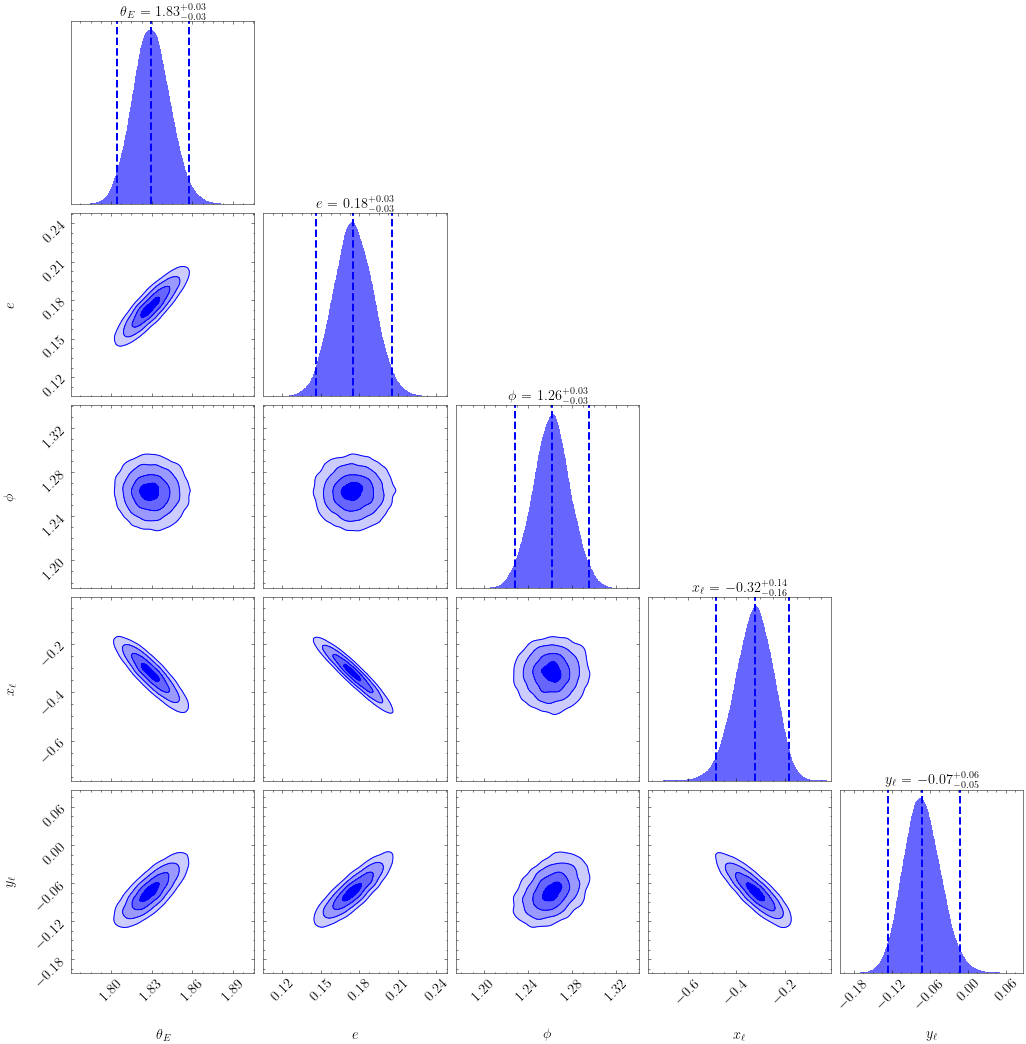

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes.reshape([5, 5])
fg, ax = dyplot.cornerplot(res, fig=(fig, axes), color="b",
                             labels=[r"$\theta_E$", r"$e$", r"$\phi$", r"$x_{\ell}$", r"$y_{\ell}$"],
                          show_titles=True)

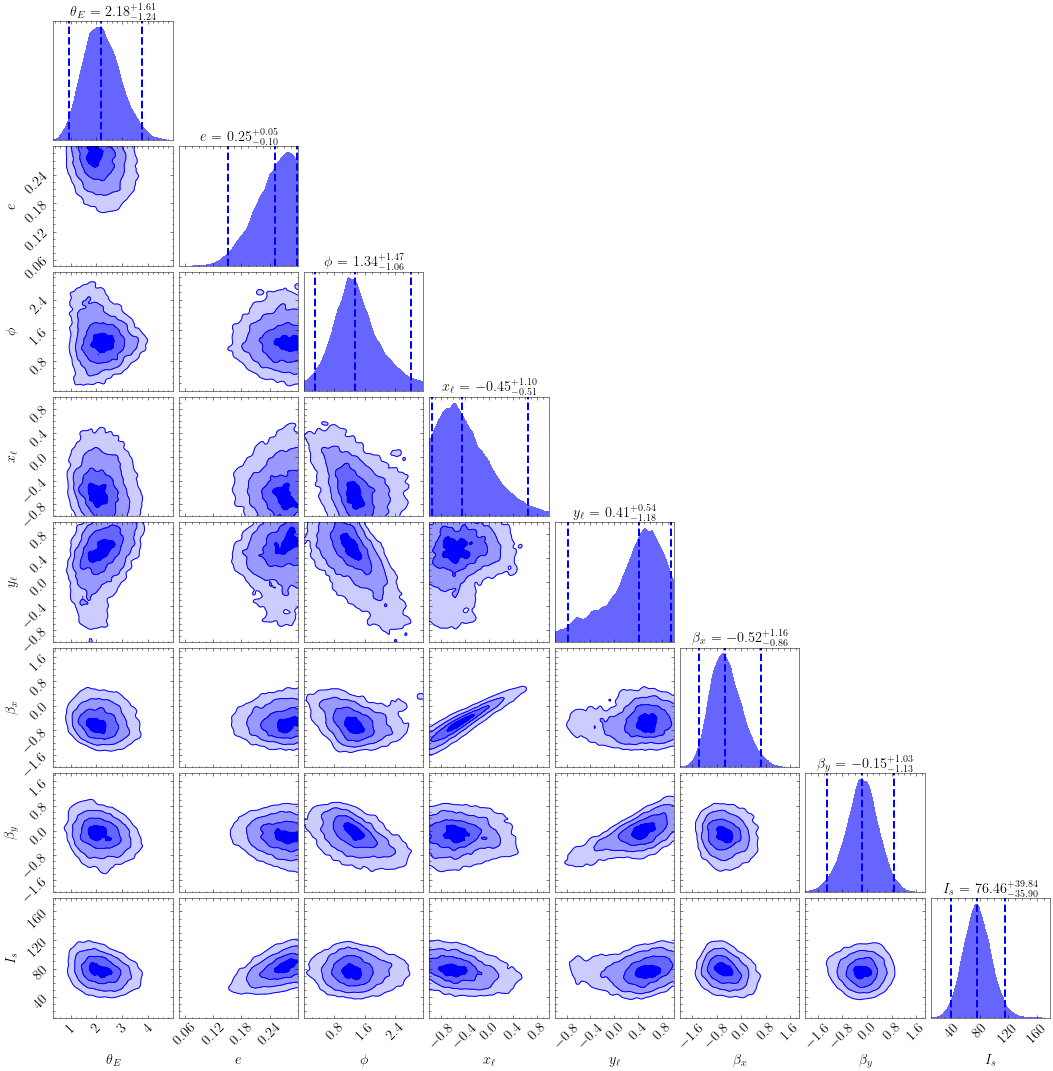

In [25]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
axes.reshape([8, 8])
fg, ax = dyplot.cornerplot(res_f, fig=(fig, axes), color="b",
                             labels=[r"$\theta_E$", r"$e$", r"$\phi$", r"$x_{\ell}$", r"$y_{\ell}$", r"$\beta_x$", r"$\beta_y$", r"$I_s$"],
                          show_titles=True)

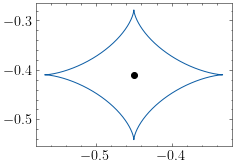

In [25]:
best = [1.83, 0.17, 1.26, -0.45, -0.41]
def caustic(params):
    r_ein, e, varphi, x0, y0 = params
    phi = np.linspace(0,2*np.pi,1000)
    f = 1 - e
    fp = np.sqrt(1.0-f**2)
    a1 = np.sqrt(f)/fp*np.arcsinh(fp/f*np.cos(phi))
    a2 = np.sqrt(f)/fp*np.arcsin(fp*np.sin(phi))
    delta = np.sqrt(np.cos(phi)**2+f**2*np.sin(phi)**2)
    r  = np.sqrt(f)/delta
    y1 = r*np.cos(phi) - a1
    y2 = r*np.sin(phi) - a2
    return y1 + x0, y2 + y0
beta_x, beta_y = quad.backward_pass(best)
beta_x = np.array(beta_x)
beta_y = np.array(beta_y)
# plt.plot(beta_x, beta_y, "ko")
plt.plot(-0.45, -0.41, "ko")
plt.plot(*caustic(best))

In [89]:
beta = np.column_stack([beta_x, beta_y])
beta_mean = np.mean(beta, axis=0)
beta_mean

array([-0.00177826, -0.59311809])